In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

## Cleaning the data

In [2]:
df : pd.DataFrame = pd.read_csv('my_data.csv')

In [3]:
df.head()

,Unnamed: 0,year,make,model,mileage,title,state of origin,engine size,engine type,drivetrain,transmmision type,number og gears,body_style,color,numberg of higlights,number of flaws,price
0,0,1999,Mercedes-Benz,SL600,"52,000",Clean,NJ,6.0L,V12,Rear-wheel drive,Automatic,5-Speed,Convertible,Black,5,3,"$30,500"
1,1,2017,BMW,330i,"43,400",Clean,KS,2.0L,I4,4WD/AWD,Automatic,8-Speed,Wagon,Glacier Silver,6,4,"$41,500"
2,2,2008,MINI,Cooper Clubman,"104,100",Clean,TN,1.6L,I4,Front-wheel drive,Manual,6-Speed,Wagon,Hot Chocolate Metallic,5,11,"$9,969"
3,3,2013,Porsche,Cayenne,"82,400",Clean,CA,4.8L,V8,4WD/AWD,Automatic,8-Speed,SUV/Crossover,Meteor Grey Metallic,4,2,"$29,000"
4,4,2019,Chevrolet,Camaro,"9,500",Clean,NY,6.2L,V8,Rear-wheel drive,Automatic,10-Speed,Coupe,Riverside Blue Metallic,4,3,"$60,333"


In [30]:
df["make"].unique()

array(['Mercedes-Benz', 'BMW', 'MINI', 'Porsche', 'Chevrolet', 'Lexus',
       'Audi', 'Jeep', 'Eagle', 'Mitsubishi', 'Dodge', 'Toyota',
       'Bentley', 'Ford', 'Jaguar', 'Subaru', 'Lincoln', 'Honda',
       'Land Rover', 'Lotus', 'Volvo', 'Mazda', 'GMC', 'Pontiac', 'Acura',
       'Ferrari', 'Volkswagen', 'Rolls-Royce', 'Nissan', 'Fiat',
       'Maserati', 'Alfa Romeo', 'Daihatsu', 'Chrysler', 'Lamborghini',
       'Morgan', 'Saturn', 'Aston Martin', 'Cadillac', 'Scion', 'Citroen',
       'Saab', 'Suzuki', 'Oldsmobile', 'Ram', 'Mercury', 'Peugeot',
       'Infiniti', 'AC', 'Hyundai', 'Buick', 'Rover', 'Isuzu', 'Polaris',
       'Hummer', 'Tesla', 'Yugo', 'Mitsuoka', 'Autozam', 'Freightliner',
       'Kia', 'Brunton', 'AM General', 'Geo', 'Datsun',
       'Stewart & Stevenson', 'Ariel', 'McLaren', 'Plymouth', 'Exomotive',
       'Laforza', 'Renault', 'CAV', 'BAC', 'Iveco', 'WaterCar', 'Lancia',
       'UAZ', 'TVR', 'Maybach', 'Austin', 'MG', 'Fisker', 'Falcon',
       'Campagna', 'Ef

In [4]:
df = df.drop("Unnamed: 0",axis=1)
df = df.drop(df.loc[df['year'] == '"Consumer'].index)

In [5]:
df["price"] = df["price"].apply(lambda x: x[1:])
df["price"] = df["price"].apply(lambda x: x.replace(",",""))

In [6]:
df["mileage"] = df["mileage"].apply(lambda x: x.replace(",",""))

In [7]:
df["engine size"] = df["engine size"].replace(['Single','Dual','Triple' ],0)
def convert(x : str):
    if isinstance(x,int):
        return x
    elif "cc" in x:
        x = x.replace("cc","")
    elif "L" in x:
        x = x.replace("L","")
        x = x.replace(".","")
        for i in range(0,4 -len(x)):
            x = x + "0"
    elif "." in x:
        x = x.replace(".","")
        for i in range(0,4 -len(x)):
            x = x + "0"

    return x

df["engine size"] = df["engine size"].apply(convert)


df.loc[df["engine size"] == "Toronto","engine size"] = 5700
df.loc[df["engine size"] == "Chevrolet","engine size"] = 3200
df.loc[df["engine size"] == "AC","engine size"] = 0
df.loc[df["engine size"] == "EV","engine size"] = 0
df.iloc[3834,6] = 4600
df.iloc[3926,6] = 4000

In [8]:
df["engine size"].unique()

array(['6000', '2000', '1600', '4800', '6200', '4700', '3200', '2500',
       '4400', '3600', '5400', '4000', '8000', '4900', '5300', '5700',
       '6750', '5000', '5500', '3000', '3500', '4500', '1300', '3300',
       '2200', '2700', '3800', '4200', '3700', '1800', '5900', '6700',
       '1700', '3400', '5200', '4600', '987', '2800', '4300', '1400',
       '2400', '2300', '6400', '6500', '660', '5800', '8300', '6600',
       '602', '659', '657', '1500', '1100', '7000', '2900', '2250',
       '5600', '2600', '0700', '7400', '7300', '1900', '7500', '6800', 0,
       '8100', '1200', '1000', '548', '658', '6300', '1080', '547',
       '8400', '3900', '656', '6100', '2100', '3100', '4100', '7200',
       3200, 4600, 4000, '0600', '2850', '6900', 5700, '1750'],
      dtype=object)

In [9]:
df["engine type"].unique()

array(['V12', 'I4', 'V8', 'I6', 'I5', 'V6', 'Flat-6', 'V10', 'Flat-4',
       'Rotary', 'turbodiesel', 'I3', '6', 'V2', 'Flat-2', '4', 'H6',
       '12-Cylinder', 'W12', '90D', 'Inline-4', 'W8', 'VR6', '3.0L',
       'Diesel', 'Motor', 'Motors', 'H4', 'Supercharged', 'I-4',
       'Turbodiesel', 'Turbo', '75', 'I-6', 'P90D', '85', 'I-3', '100D',
       '75D', 'generator', 'Canada', 'P85', 'EV', 'i4', 'motor', 'Hybrid'],
      dtype=object)

In [10]:
df.loc[df["engine type"] == "Canada","engine type"] = "Flat-6"
df.loc[df["engine type"] == "Supercharged","engine type"] = "V6"
df.loc[df["engine type"] == "Diesel","engine type"] = "I4"
df.loc[df["engine type"] == "3.0L","engine type"] = "I6"
df.loc[df["engine type"] == "turbodiesel","engine type"] = "I6"
df.loc[df["engine type"] == "I-6","engine type"] = "I6"
df.loc[df["engine type"] == "Turbodiesel","engine type"] = "V6"
df.loc[df["engine type"] == "Turbo","engine type"] = "I4"
df.loc[df["engine type"] == "4","engine type"] = "Flat-4"
df.loc[df["engine type"] == "6","engine type"] = "Flat-6"
df.loc[df["engine type"] == "Inline-4","engine type"] = "I4"
df.loc[df["engine type"] == "i4","engine type"] = "I4"
df.loc[df["engine type"] == "I-4","engine type"] = "I4"
df.loc[df["engine type"] == "I-3","engine type"] = "I3"
df.loc[df["engine type"] == "Hybrid","engine type"] = "V6"
df.loc[df["engine size"] == 0,"engine type"] = "electric"

In [11]:
def get_miles_from_str(x):
    if isinstance(x,int):
        return x
    x = x.split(" ")[0]
    x = x.replace("~","")
    print(x)
    if x[0].isdigit():
        return x
    return 0

df["mileage"] = df["mileage"].apply(lambda x: get_miles_from_str(x))

52000
43400
104100
82400
9500
160100
72200
20400
144600
45200
74200
123100
300
56300
52200
46100
3200
85200
40900
117600
68700
30500
90600
95300
179600
48000
122800
99000
8000
41900
17500
46400
146700
36500
84100
68300
59900
81100
15900
106200
91200
9100
38300
143500
14900
213400
217100
150900
228700
81000
22900
10700
6400
137000
56700
102900
85200
164100
176400
82500
122900
77400
9
153500
249200
114000
33500
57500
200700
57300
196900
84100
112100
13100
1300
114100
51000
93100
2100
201200
12300
104300
19500
101200
26600
47600
149200
64200
189200
90900
24500
168000
72900
97200
87800
109600
38900
137400
157200
52000
72300
64000
182400
150000
104200
27500
155100
90100
13900
35300
8500
73600
182500
49700
205000
85700
71000
74300
128000
47400
68400
68500
85300
41600
10600
255900
85000
18
119500
18500
33100
66800
93600
56800
134300
124600
10500
38500
55100
184100
82100
112700
82100
93300
55500
75500
35000
88500
92700
91800
109900
59200
125900
156700
38400
120500
36700
192600
30600
25100
3960

In [12]:
df.loc[df["number og gears"] == "3.6L V6","number og gears"] = "6-speed"
def simplefy_gears(x:str):
    if not isinstance(x,str):
        return 0
    print(x)
    if x == "CVT":
        return -1
    x = x.split("-")[0]
    return x

df["number og gears"] = df["number og gears"].apply(simplefy_gears)

5-Speed
8-Speed
6-Speed
8-Speed
10-Speed
5-Speed
5-Speed
5-Speed
5-Speed
7-Speed
5-Speed
5-Speed
8-Speed
5-Speed
5-Speed
6-Speed
6-Speed
6-Speed
9-Speed
6-Speed
5-Speed
6-Speed
6-Speed
4-Speed
6-Speed
4-Speed
5-Speed
4-Speed
6-Speed
4-Speed
8-Speed
6-Speed
5-Speed
6-Speed
5-Speed
7-Speed
6-Speed
6-Speed
10-Speed
6-Speed
7-Speed
8-Speed
5-Speed
5-Speed
6-Speed
6-Speed
4-Speed
5-Speed
6-Speed
6-Speed
5-Speed
5-Speed
10-Speed
6-Speed
5-Speed
7-Speed
6-Speed
5-Speed
5-Speed
4-Speed
6-Speed
4-Speed
10-Speed
6-Speed
4-Speed
5-Speed
6-Speed
5-Speed
5-Speed
4-Speed
6-Speed
5-Speed
5-Speed
5-Speed
6-Speed
6-Speed
7-Speed
5-Speed
8-Speed
5-Speed
6-Speed
6-Speed
6-Speed
5-Speed
7-Speed
6-Speed
6-Speed
5-Speed
4-Speed
6-Speed
6-Speed
5-Speed
6-Speed
5-Speed
4-Speed
6-Speed
5-Speed
5-Speed
6-Speed
4-Speed
5-Speed
6-Speed
4-Speed
5-Speed
6-Speed
4-Speed
6-Speed
6-Speed
6-Speed
6-Speed
7-Speed
6-Speed
5-Speed
5-Speed
4-Speed
6-Speed
4-Speed
7-Speed
6-Speed
6-speed
5-Speed
8-Speed
3-Speed
5-Speed
5-Sp

In [13]:

df["price"] = df['price'].astype(str).astype(int)
df["mileage"] = df['mileage'].astype(str).astype(int)
df["year"] = df['year'].astype(str).astype(int)
df["engine size"] = df['engine size'].astype(str).astype(int)
df["number og gears"] = df['number og gears'].astype(str).astype(int)

In [14]:
def simplefy_color(x : str):
    if "white" in x.lower():
        x = "white"
    elif "black" in x.lower():
        x = "black"
    elif "red" in x.lower():
        x = "red"
    elif "blue" in x.lower():
        x = "blue"
    elif "yellow" in x.lower():
        x = "yellow"
    elif "grey" in x.lower():
        x = "grey"
    elif "green" in x.lower():
        x = "green"
    elif "silver" in x.lower():
        x = "silver"
    elif "orange" in x.lower():
        x = "orange"
    elif "metallic" in x.lower():
        x = "metallic"
    elif "pearl" in x.lower():
        x = "pearl"
    elif "gold" in x.lower():
        x = "gold"
    elif "beige" in x.lower():
        x = "beige"
    else:
        return "special"

    return x

df["color"] = df["color"].apply(simplefy_color)
df["color"].value_counts(ascending=True)

gold          13
beige         17
orange        47
yellow        86
pearl        109
grey         165
green        220
metallic     373
special      429
red          575
blue         660
white        727
silver       834
black       1164
Name: color, dtype: int64

In [15]:
df.loc[df["color"] == "gold"]

,year,make,model,mileage,title,state of origin,engine size,engine type,drivetrain,transmmision type,number og gears,body_style,color,numberg of higlights,number of flaws,price
209,1986,Porsche,944,55800,Clean,TX,2500,I4,Rear-wheel drive,Manual,5,Coupe,gold,6,15,13500
358,2006,Honda,S2000,62000,Clean,FL,5700,V8,Rear-wheel drive,Manual,6,Convertible,gold,5,9,25550
2482,1989,Honda,Prelude,40300,Clean,NY,2000,I4,Front-wheel drive,Automatic,4,Coupe,gold,6,4,10000
2564,1993,Toyota,Land Cruiser,149600,Clean,CA,4000,I6,4WD/AWD,Manual,5,SUV/Crossover,gold,6,10,13500
2981,2006,Jaguar,XJ8,32700,Clean,AR,4200,V8,Rear-wheel drive,Automatic,6,Sedan,gold,5,1,13500
3431,1988,Dodge,Ram Van,41400,Clean,CA,5200,V8,Rear-wheel drive,Automatic,3,Van/Minivan,gold,5,4,8800
4037,2004,Ford,Excursion,38400,Clean,CA,6000,V8,Rear-wheel drive,Automatic,5,SUV/Crossover,gold,5,5,25250
4044,1987,Honda,Accord,85500,Clean,WA,2000,I4,Front-wheel drive,Manual,5,Sedan,gold,6,0,2900
4307,2015,Land Rover,Range Rover Sport,57800,Clean,CT,5000,V8,4WD/AWD,Automatic,8,SUV/Crossover,gold,7,4,35500
4696,1989,Merkur,Scorpio,19300,Clean,PA,2900,V6,Rear-wheel drive,Automatic,4,Sedan,gold,5,8,12500


In [16]:
df = df.drop("title",axis=1)

In [17]:
df["is descreptive"] = df["numberg of higlights"] + df["number of flaws"] > 10
df["is descreptive"] = df["is descreptive"].map({
    True: 1,
    False: 0
})

df = df.drop(["numberg of higlights","number of flaws"],axis=1)

In [18]:
df["number og gears"].value_counts()

 6     1844
 5     1594
 4      915
 7      516
 8      346
 3       84
 10      39
 0       37
 9       33
-1        5
 1        4
 2        2
Name: number og gears, dtype: int64

In [19]:
df.loc[df["number og gears"] == "3.6L V6"]

,year,make,model,mileage,state of origin,engine size,engine type,drivetrain,transmmision type,number og gears,body_style,color,price,is descreptive


In [20]:
df.head()

,year,make,model,mileage,state of origin,engine size,engine type,drivetrain,transmmision type,number og gears,body_style,color,price,is descreptive
0,1999,Mercedes-Benz,SL600,52000,NJ,6000,V12,Rear-wheel drive,Automatic,5,Convertible,black,30500,0
1,2017,BMW,330i,43400,KS,2000,I4,4WD/AWD,Automatic,8,Wagon,silver,41500,0
2,2008,MINI,Cooper Clubman,104100,TN,1600,I4,Front-wheel drive,Manual,6,Wagon,metallic,9969,1
3,2013,Porsche,Cayenne,82400,CA,4800,V8,4WD/AWD,Automatic,8,SUV/Crossover,grey,29000,0
4,2019,Chevrolet,Camaro,9500,NY,6200,V8,Rear-wheel drive,Automatic,10,Coupe,blue,60333,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5419 entries, 0 to 5419
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   year               5419 non-null   int64 
 1   make               5419 non-null   object
 2   model              5419 non-null   object
 3   mileage            5419 non-null   int64 
 4   state of origin    5419 non-null   object
 5   engine size        5419 non-null   int64 
 6   engine type        5419 non-null   object
 7   drivetrain         5419 non-null   object
 8   transmmision type  5419 non-null   object
 9   number og gears    5419 non-null   int64 
 10  body_style         5419 non-null   object
 11  color              5419 non-null   object
 12  price              5419 non-null   int64 
 13  is descreptive     5419 non-null   int64 
dtypes: int64(6), object(8)
memory usage: 635.0+ KB


array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'mileage'}>],
       [<AxesSubplot:title={'center':'engine size'}>,
        <AxesSubplot:title={'center':'number og gears'}>],
       [<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'is descreptive'}>]], dtype=object)

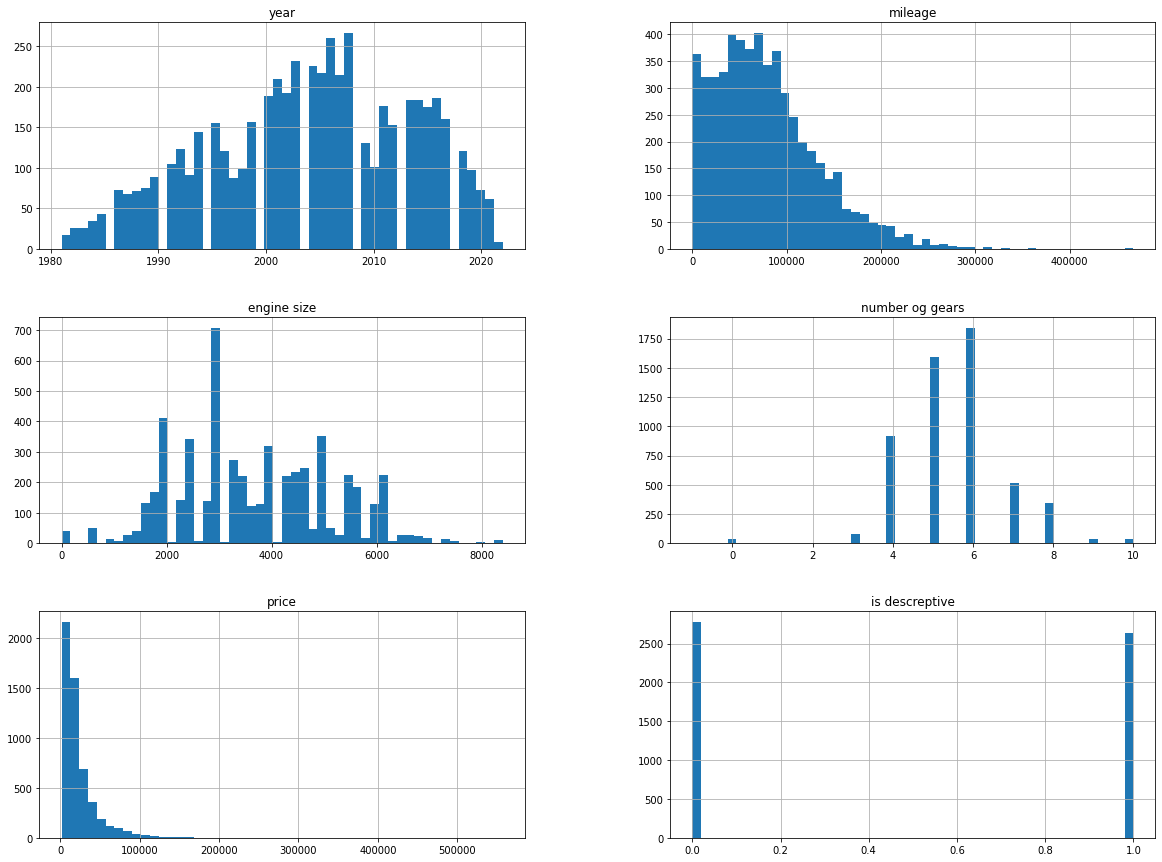

In [22]:
df.hist(bins=50, figsize=(20,15))

In [23]:
cars_df_with_dummies = pd.get_dummies(df)

In [24]:
std_scaler = StandardScaler()

price_label = cars_df_with_dummies['price']
cars_without_price = cars_df_with_dummies.drop(['price'],axis=1)

X_train,X_test,y_train,y_test = train_test_split(cars_without_price,price_label,test_size=0.2,random_state=0)


X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)



In [25]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
initial_prediction = linear_reg.predict(X_test)


print(linear_reg.score(X_test,y_test))
print (mean_squared_error(y_test,initial_prediction))

0.7679859577706188
158074591.14378464


0.16276065694777633


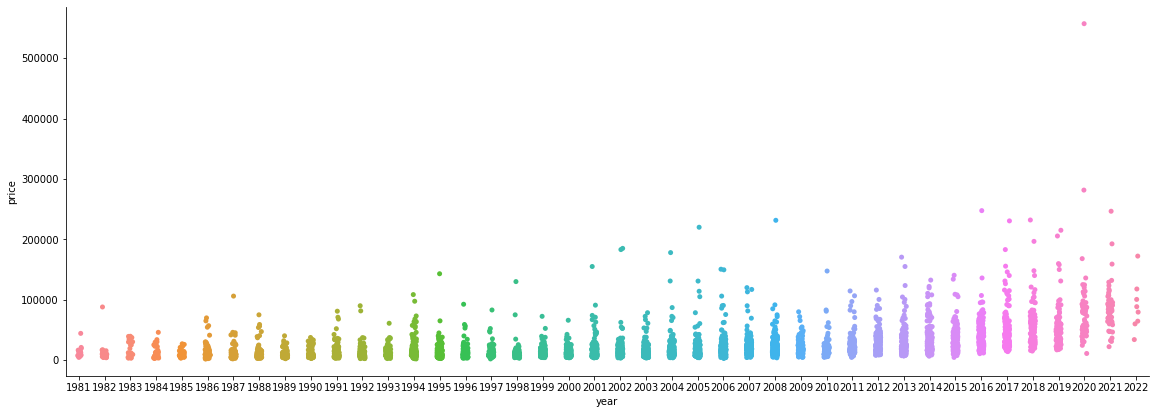

In [26]:
cars_cat_plot_price_year = sns.catplot(x="year", y="price" ,data=df)
cars_cat_plot_price_year.fig.set_figwidth(20)
cars_cat_plot_price_year.fig.set_figheight(6)

print(df.loc[df["year"]>2014].size/df.size)

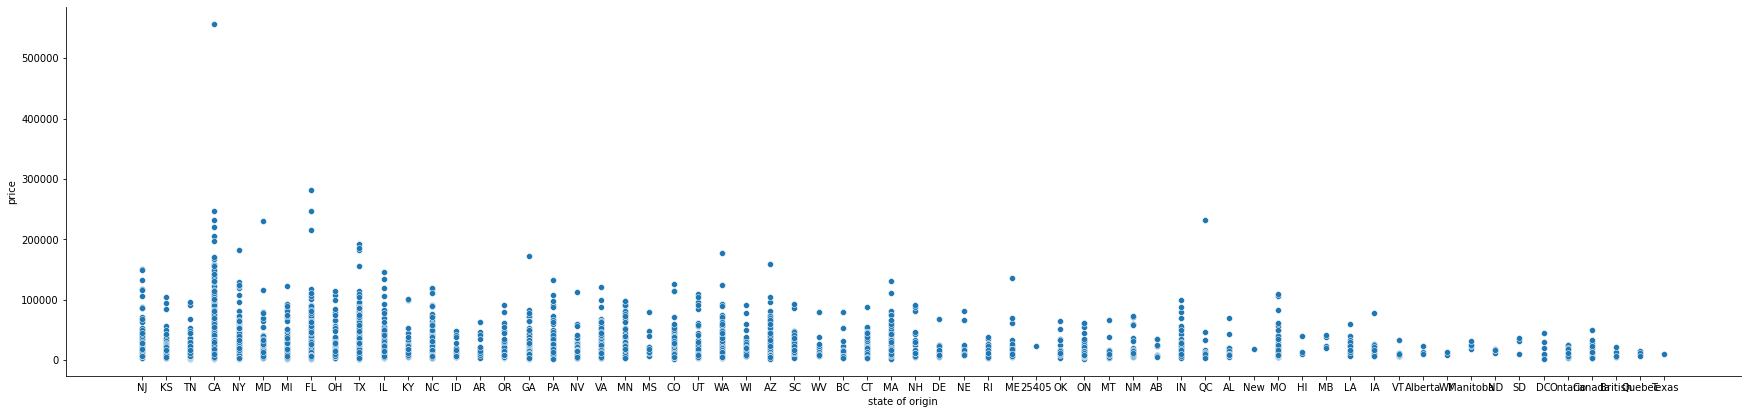

In [32]:
origin_price_rel = sns.relplot(x="state of origin", y="price" ,data=df)
origin_price_rel.fig.set_figwidth(30)
origin_price_rel.fig.set_figheight(6)

<AxesSubplot:xlabel='year', ylabel='counts'>

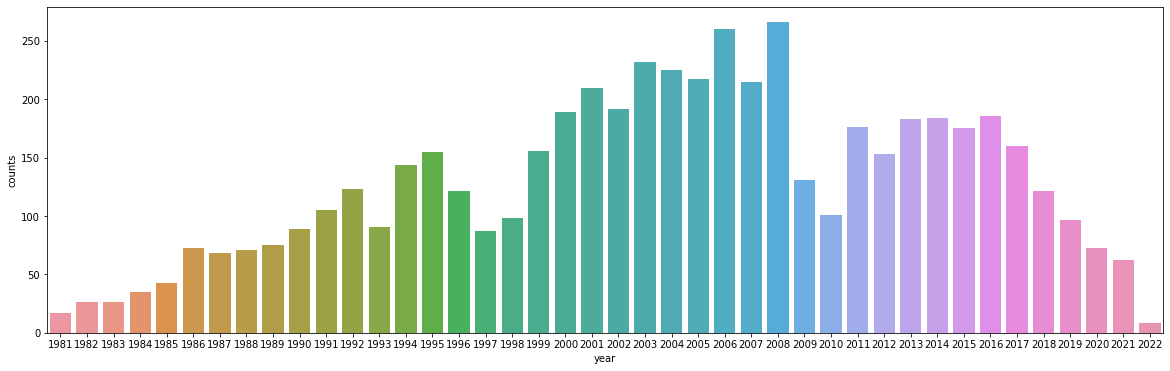

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
amount_per_year=df["year"].value_counts().rename_axis('year').reset_index(name='counts')
sns.barplot(x="year", y="counts",data=amount_per_year)

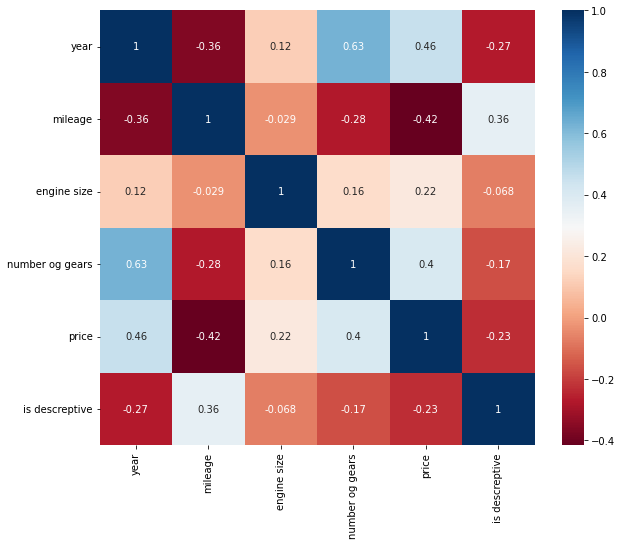

In [29]:
colormap = plt.cm.RdBu
sns.heatmap(df.corr(), annot=True, cmap=colormap,square=True )
fig = plt.gcf()
fig.set_size_inches(10, 8)

plt.show()